# <center> MERA 

#### <center> with D

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorcircuit as tc
tc.set_backend("tensorflow")
tc.set_dtype("complex128")

('complex128', 'float64')

## energy
$$ \hat{H}_{Ising}=J\sum_{i}{Z_{i}Z_{i+1}}-B_{x}\sum_{i}{X_{i}} $$

In [4]:
def energy(c: tc.Circuit, j: float = 1.0, h: float = 1.0):
    e = 0.0
    n = c._nqubits
    for i in range(n):
        e -= h * c.expectation((tc.gates.x(), [i]))  # <X_i>
    for i in range(n-1):  
        e += j * c.expectation(
            (tc.gates.z(), [i]), (tc.gates.z(), [i+1])
        )  # <Z_i Z_{i+1}>
    return tc.backend.real(e)

## MERA net

In [5]:
def MERA(params, n, d):
    params = tc.backend.cast(params, "complex128")
    c = tc.Circuit(n)
    
    idx = 0
    
    for i in range(n):
        c.rx(i, theta=params[2*i])
        c.rz(i, theta=params[2*i+1])
    idx += 2*n
    
    for n_layer in range(1, int(np.log2(n))+1):
        n_qubit = 2**n_layer   # 参与计算的qubit数
        step = int(n / n_qubit)

        for _ in range(d):
            # even    
            for i in range(step, n-step, 2*step):
                c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
                c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
                idx += 2
            
            # odd   
            for i in range(0, n, 2*step):
                c.exp1(i, i+step, theta=params[idx], unitary=tc.gates._xx_matrix)
                c.exp1(i, i+step, theta=params[idx+1], unitary=tc.gates._zz_matrix)
                idx += 2
        
        for i in range(0, n, step):
            c.rx(i, theta=params[idx])
            c.rz(i, theta=params[idx+1])
            idx += 2
        

    # measure
    e = energy(c)
    return e 
    #return c, idx

196


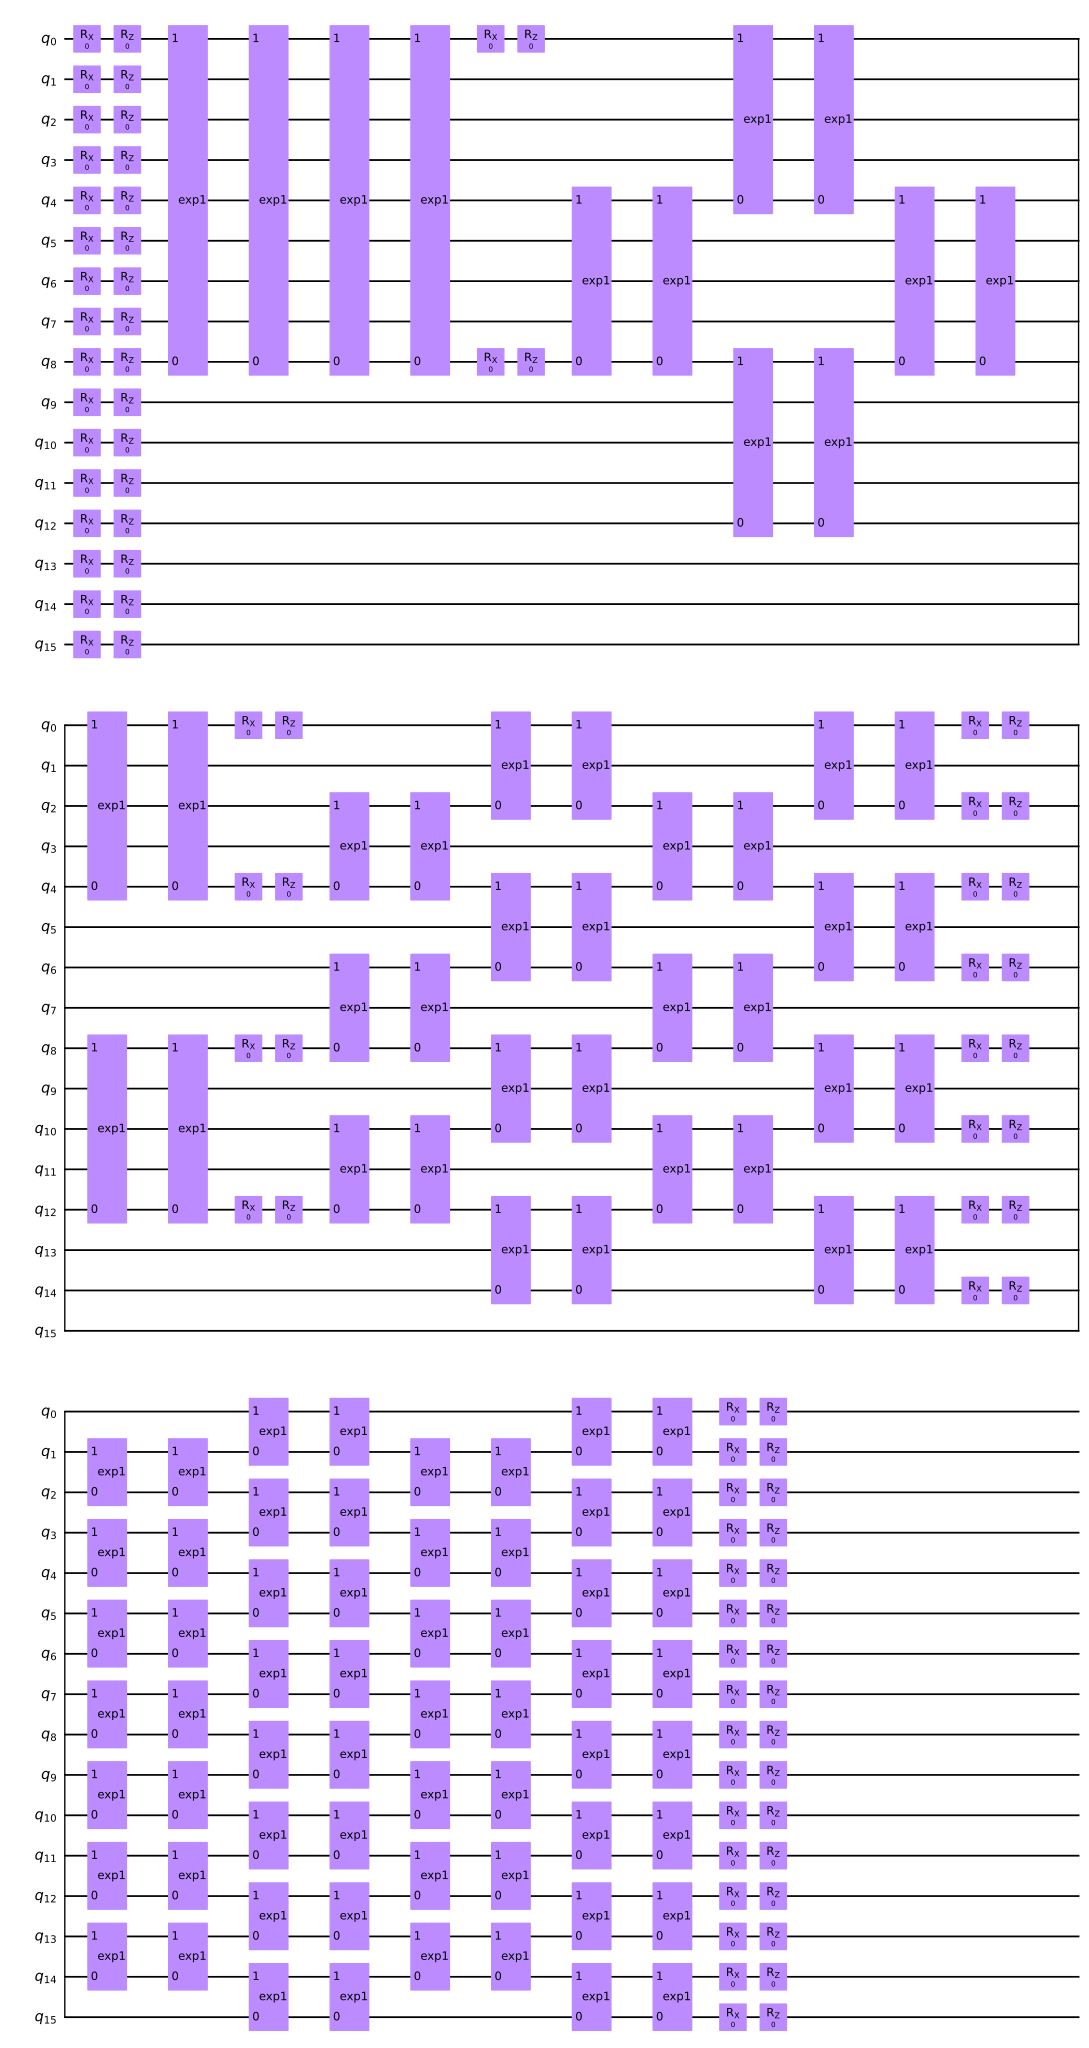

In [6]:
cirq, idx = MERA(np.zeros(1000), 16, 2)
print(idx)
cirq.draw()

## train

In [8]:
MERA_tfim_vvag = tc.backend.jit(
    tc.backend.vectorized_value_and_grad(MERA)
)

def batched_train(n, d, batch=10, maxiter=10000, lr=0.005):
    params = tf.Variable(
        initial_value=tf.random.normal(
            shape=[batch, idx], stddev=1, dtype=getattr(tf, tc.rdtypestr)
        )
    )
    opt = tf.keras.optimizers.Adam(lr)
    lowest_energy = 1e5
    for i in range(maxiter):
        e, grad = MERA_tfim_vvag(params, n, d)
        opt.apply_gradients([(grad, params)])
        if tf.reduce_min(e)<lowest_energy:
            lowest_energy = tf.reduce_min(e)
        if i % 200 == 0:
            print(e)
    return lowest_energy

In [9]:
n = 16
d = 2
with tf.device('/cpu:0'):
    energy = batched_train(n, d, batch=5, maxiter=2000, lr=0.007)

tf.Tensor([1.3547194  0.55089096 0.04095338 0.01826203 0.34431041], shape=(5,), dtype=float64)
tf.Tensor([-19.55002418 -19.66983539 -19.69924088 -19.12609046 -19.68334129], shape=(5,), dtype=float64)
tf.Tensor([-19.77851685 -19.73408372 -19.75751883 -19.33566558 -19.76687274], shape=(5,), dtype=float64)
tf.Tensor([-19.78811631 -19.75476513 -19.78170875 -19.76450997 -19.78243861], shape=(5,), dtype=float64)
tf.Tensor([-19.80234159 -19.77255936 -19.79883759 -19.77560319 -19.788834  ], shape=(5,), dtype=float64)
tf.Tensor([-19.81610969 -19.79073396 -19.82252642 -19.7910823  -19.79297788], shape=(5,), dtype=float64)
tf.Tensor([-19.82279289 -19.79800935 -19.84235295 -19.80353805 -19.79657971], shape=(5,), dtype=float64)
tf.Tensor([-19.82742383 -19.80199505 -19.85991983 -19.81517782 -19.80089835], shape=(5,), dtype=float64)
tf.Tensor([-19.83080187 -19.80479988 -19.86640459 -19.81833323 -19.80625865], shape=(5,), dtype=float64)
tf.Tensor([-19.83490167 -19.80729687 -19.87227764 -19.82047676 -1

## compare

In [10]:
# DMRG
import quimb
h = quimb.tensor.tensor_gen.MPO_ham_ising(n, j=4., bx=2., S=0.5, cyclic=False)  # Ising Hamiltonian in MPO form (number, zz interaction strenth, x-magnetic field strenth)
dmrg = quimb.tensor.tensor_dmrg.DMRG(h, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-13)
dmrg.solve(tol=1e-9, verbosity=0)
energy0 = dmrg.energy

#compare
print("\n")
print("DMRG solution: ", energy0)
print("MERA solution: ", energy.numpy())



DMRG solution:  -20.01638790048168
MERA solution:  -19.879419584618496
